In [25]:
from torch.autograd import Variable
import torch
import torch.autograd
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from tqdm import tqdm
import pickle as pkl
from os.path import join as oj
import numpy.random as npr
import numpy.linalg as npl
from copy import deepcopy
import pandas as pd
import seaborn as sns
import viz
from numpy import array as arr

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# analyze results

In [30]:
from params_interactions import p

# depending on how much is saved, this may take a while
out_dir = oj('/scratch/users/vision/yu_dl/raaz.rsk/interactions/',
#             'x1=x2+eps=00_sgd_no_bias')
#             '/scratch/users/vision/yu_dl/raaz.rsk/interactions/x1=x2+eps=0.1_sweep_width_depth') # hidden_size, num_layers, eps
#             'x1=x2+eps=00')
            'x1=x2+eps=0.1_small_sweep_adam') # num_layers, hidden_size
# x1=x2+eps=00_sgd
fnames = sorted([fname for fname in os.listdir(out_dir)])

results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames]
results = pd.concat(results_list, axis=1, sort=False).T.infer_objects()

### analyze hidden layer dependence

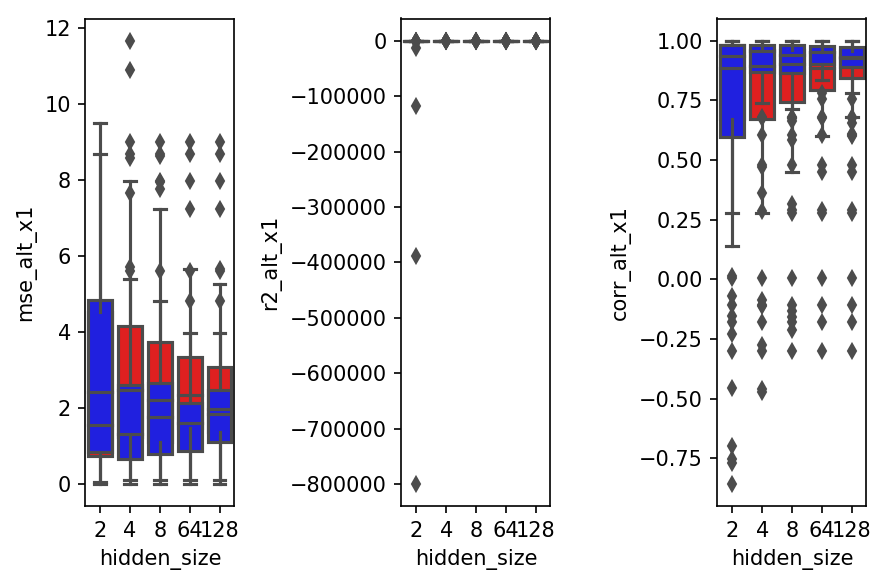

In [34]:
r = results
# r = r[r.hidden_size == 64]
axis = 'hidden_size'
# r = r[r.eps == 0.1]


plt.figure(dpi=150)
# sns.boxplot(data=r, x='num_layers', y='mse_test')
R, C = 1, 3


plt.subplot(R, C, 1)
ax = sns.boxplot(data=r, x=axis, y='mse_alt_x0', color='red')

sns.boxplot(data=r, x=axis, y='mse_alt_x1', color='blue')
# plt.yscale('log')

plt.subplot(R, C, 2)
sns.boxplot(data=r, x=axis, y='r2_alt_x0', color='red')
sns.boxplot(data=r, x=axis, y='r2_alt_x1', color='blue')

plt.subplot(R, C, 3)
sns.boxplot(data=r, x=axis, y='corr_alt_x0', color='red')
sns.boxplot(data=r, x=axis, y='corr_alt_x1', color='blue')

plt.tight_layout()
plt.show()

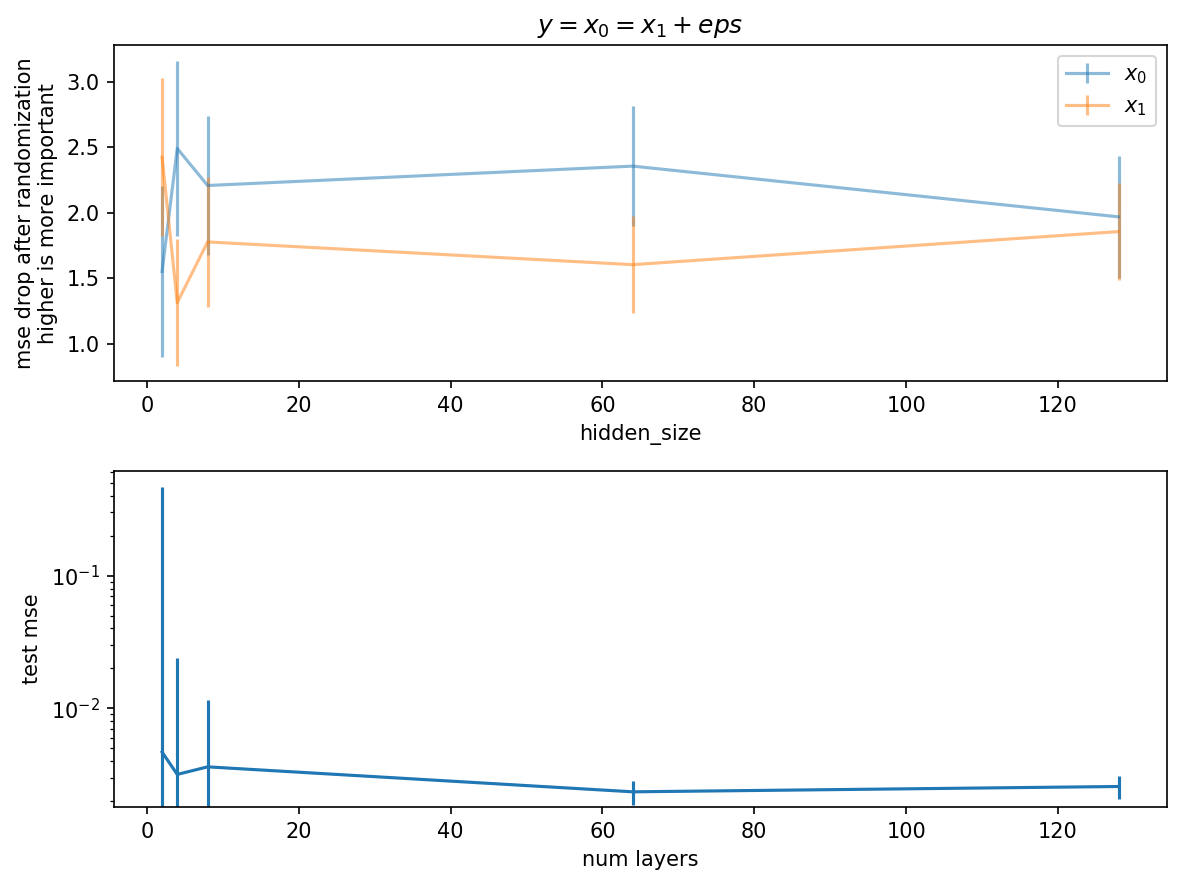

In [38]:
vals = r.groupby([axis])
vals_mean = vals.median().reset_index().sort_values(by=axis)
vals_var = vals.var().reset_index().sort_values(by=axis)

num_vars = 2 # how many vars are we interested in?
num_sweep = 7 # how many things did we sweep over?

xs = vals_mean[axis]

plt.figure(dpi=150, figsize=(8, 6))
plt.subplot(211)
for i in range(num_vars):
    ys = vals_mean['mse_alt_x' + str(i)]# vals_mean['mse_alt_x' + str(i)]# -1 * (vals_mean['mse_test'] - vals_mean['mse_alt_x' + str(i)])
    ystd = 1.96 * np.sqrt(vals_var['mse_alt_x' + str(i)]) / np.sqrt(vals.size().values)
    plt.errorbar(xs, ys, yerr=ystd, label=f'$x_{i}$', alpha=0.5)
plt.xlabel(axis)
plt.ylabel('mse drop after randomization\nhigher is more important')
plt.title(f'${p.func}$')
plt.legend()

plt.subplot(212)
# plt.errorbar(xs, vals_mean['mse_test'], yerr=np.sqrt(vals_var['mse_test']) / np.sqrt(vals.size().values))
plt.errorbar(xs, vals_mean['mse_test'], yerr=1.96 * np.sqrt(vals_var['mse_test']) / np.sqrt(vals.size().values))
plt.xlabel('num layers')
plt.ylabel('test mse')
plt.yscale('log')
plt.tight_layout()
plt.show()

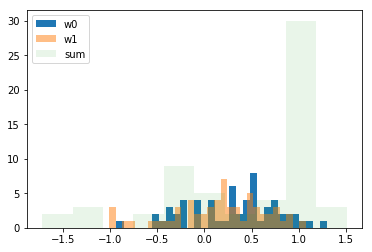

In [24]:
w0s, w1s = [], []
rs = r[r.num_layers == 1]
rs = r[r.d ==2]
for i in range(rs.shape[0]):
    row = rs.iloc[i]
#     print(row['w'][-1], row['w'][-1].sum())
    w0s.append(row['w'][0])
    w1s.append(row['w'][1])      

w0s = arr(w0s)
w1s = arr(w1s)
wsum = w0s + w1s
# idxs = wsum >= 0.9
idxs = w0s == w0s
    
plt.hist(w0s[idxs], bins=30, label='w0')
plt.hist(w1s[idxs], alpha=0.5, bins=30, label='w1')
plt.hist(wsum[idxs], label='sum', alpha=0.1)
plt.legend()
plt.show()

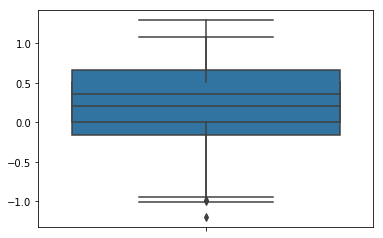

In [15]:
sns.boxplot(y=w1s)
sns.boxplot(y=w0s)
# sns.boxplot(data=r, x='num_layers', y='mse_alt_x0', color='red')

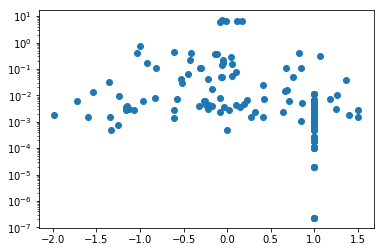

In [16]:
plt.plot(wsum[idxs], rs.mse_test[idxs], 'o')
plt.yscale('log')